In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, \
    Dense, Flatten, BatchNormalization, Activation
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

## Load MNIST

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Data Processing

In [3]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
def show_sample(num_sample=1):
    """
    Showing a 'num_sample' of each digit class from testset
    Params:
    --- 
    num_sample: int, default = 1
        number of sample of a class will be plotted 
    ---
    """
    count = [num_sample for i in range(10)]
    sample = [[] for _ in range(10)]
    idx = 0
    while sum(count) > 0:
        label = y_test[idx]
        if count[label] > 0:
            sample[label].append(x_test[idx])
            count[label] -= 1
        else:             
            idx += 1
            continue
        idx += 1
            
    
    for batch in range(num_sample):
        fig, ax = plt.subplots(1, 10, figsize=[20, 2], layout="constrained")
        for i in range(10):   
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].imshow(sample[i][batch], cmap='gray')

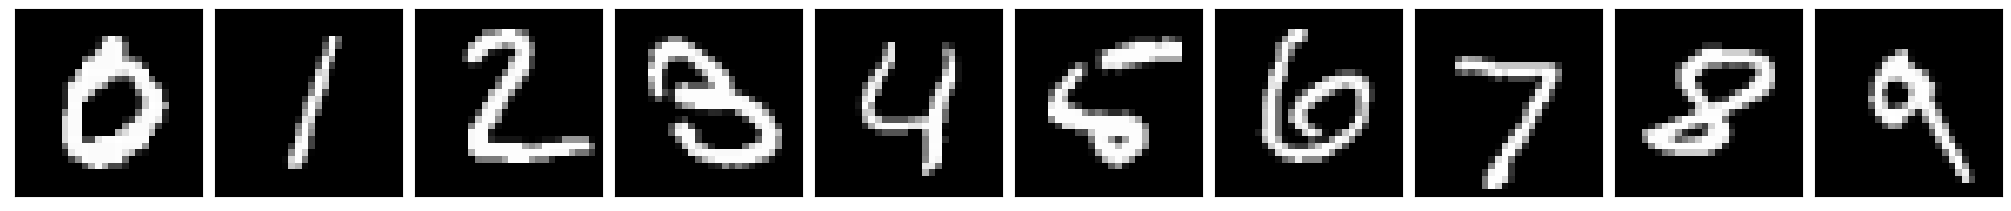

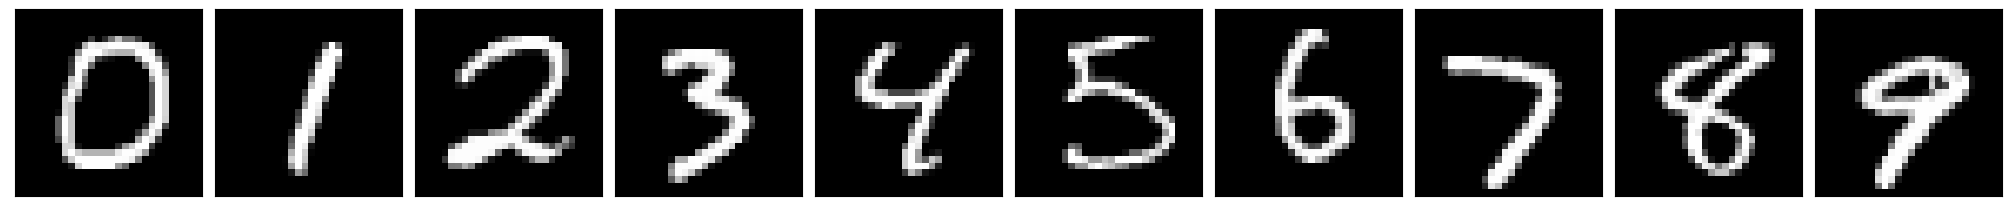

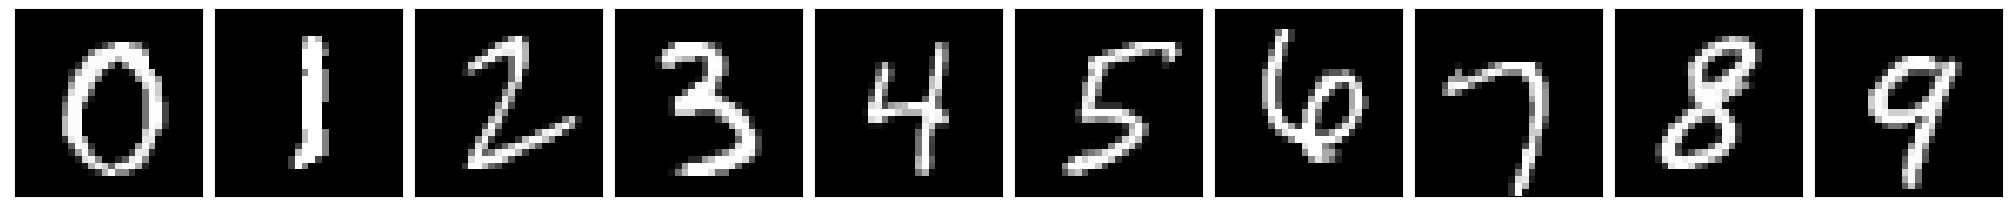

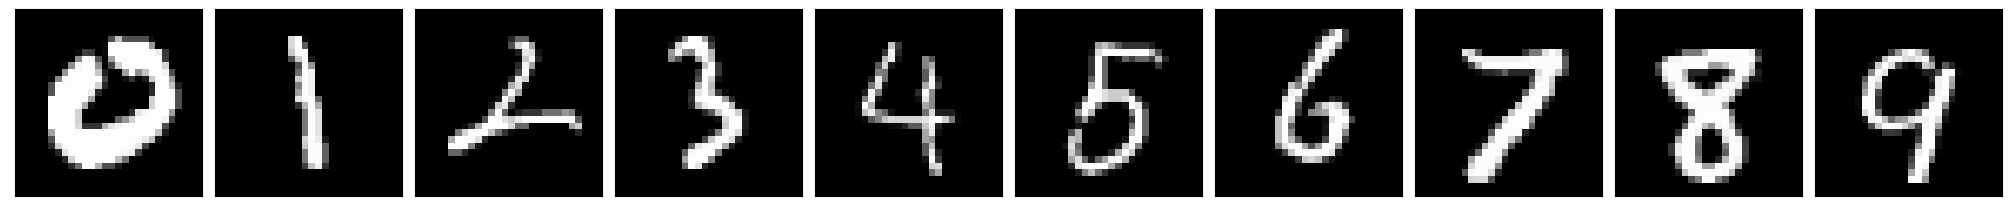

In [5]:
show_sample(num_sample=4)

### one-hot encoding

In [6]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Modeling

In [7]:
kernel_s3 = (3, 3)
kernel_s5 = (5, 5)

In [8]:
model = Sequential(
    [
        Input(shape=input_shape),

        Conv2D(16, kernel_size=kernel_s5, activation="relu", kernel_regularizer=l2(0.0005), name="conv2d_1"),
        # Conv2D(32, kernel_size=kernel_size, activation="relu", name="conv2d_2"),
        Conv2D(16, kernel_size=kernel_s5, use_bias=False,name="conv2d_3"),
        # Conv2D(64, kernel_size=kernel_size, activation="relu", name="conv2d_4"),
        BatchNormalization(name="batchnorm_1"), 

        Activation("relu"),
        MaxPooling2D(pool_size=(2,2), strides=2, name="maxpool2d_1"),
        Dropout(0.25, name="dropout_1"),
        
        Conv2D(32, kernel_size=kernel_s3, activation="relu", name="conv2d_5"),
        Conv2D(32, kernel_size=kernel_s3, use_bias=False, name="conv2d_6"),
        BatchNormalization(name="batchnorm_2"), 
        
        Activation("relu"),
        MaxPooling2D(pool_size=(2,2), strides=2, name="maxpool2d_2"),
        Dropout(0.25, name="dropout_2"),
        Flatten(name="flatten"),
        
        Dense(32, "relu", name="fc1"),
        BatchNormalization(name="batchnorm_3"), 
        
        Dense(16, "relu", name="fc2"),
        BatchNormalization(name="batchnorm_4"), 
        # Dense(16, "relu", name="fc3"),
        Dense(num_classes, activation="softmax", name="output"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        6400      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 20, 20, 16)       64        
 tion)                                                           
                                                                 
 activation (Activation)     (None, 20, 20, 16)        0         
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 10, 10, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 16)        0         
                                                        

In [9]:
batch_size = 64
epochs = 10
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

In [10]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 22s 54ms/step - loss: 0.5867 - accuracy: 0.8459 - val_loss: 0.3582 - val_accuracy: 0.9179
Epoch 2/10
375/375 [==============================] - 19s 51ms/step - loss: 0.1229 - accuracy: 0.9682 - val_loss: 0.0636 - val_accuracy: 0.9827
Epoch 3/10
375/375 [==============================] - 19s 52ms/step - loss: 0.0812 - accuracy: 0.9776 - val_loss: 0.0454 - val_accuracy: 0.9876
Epoch 4/10
375/375 [==============================] - 20s 53ms/step - loss: 0.0670 - accuracy: 0.9806 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 5/10
375/375 [==============================] - 27s 71ms/step - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.0330 - val_accuracy: 0.9908
Epoch 6/10
375/375 [==============================] - 24s 65ms/step - loss: 0.0506 - accuracy: 0.9854 - val_loss: 0.0316 - val_accuracy: 0.9909
Epoch 7/10
375/375 [==============================] - 24s 65ms/step - loss: 0.0459 - accuracy: 0.9865 - val_loss: 0.0308 - val_accuracy:

## Evaluation

In [11]:
def plot_history(history, metrics, model_name:str):
    fig = plt.figure(figsize=[8, 4])
    for metric in metrics:
        plt.plot(history.history[metric], label='train '+ metric)
        plt.plot(history.history['val_' + metric], label='val ' + metric)        
    plt.legend()    
    plt.xlabel('epoch')
    plt.ylabel(" ".join(metrics))
    plt.xticks(list(range(0, len(history.history[metrics[0]]), 2)))
    plt.grid(visible=True)
    plt.title(model_name + " training history [" + " ".join(metrics) + "]")

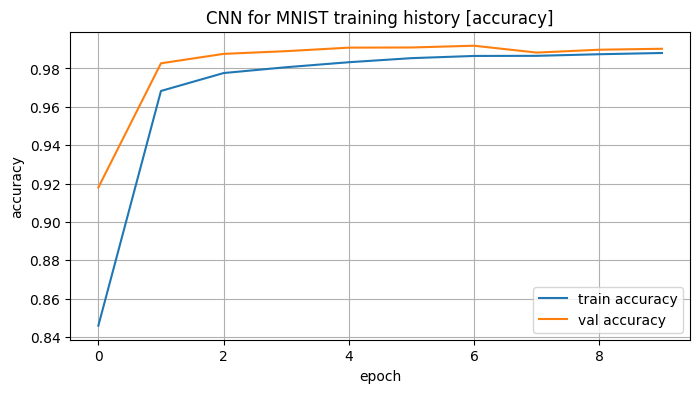

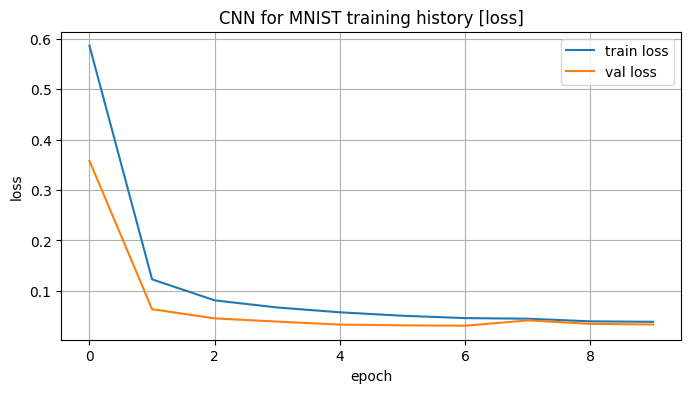

In [12]:
plot_history(history=history, metrics=["accuracy"],model_name="CNN for MNIST")
plot_history(history=history, metrics=["loss"],model_name="CNN for MNIST")

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0255 - accuracy: 0.9927


[0.025451920926570892, 0.9926999807357788]